# Classification d'images

### Imports

In [40]:
# Pandas & numpy pour la manipulation des donnees
import pandas as pd
import numpy as np
import cv2


#division des donnees en training & testing
from sklearn.model_selection import train_test_split

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# taille de police par defaut
plt.rcParams['font.size'] = 24

# taille de figures
from IPython.core.pylabtools import figsize

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Models d'aprentissage machine
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Mise à jour des hyperparametres
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from numpy import genfromtxt
from scipy import ndimage

### Fonctions utiles

In [41]:
def centerimg(im):
# Determine Centre of Mass

    com = ndimage.measurements.center_of_mass(im)
    # Translation distances in x and y axis

    x_trans = int(im.shape[0]//2-com[0])
    y_trans = int(im.shape[1]//2-com[1])

    # Pad and remove pixels from image to perform translation

    if x_trans > 0:
        im2 = np.pad(im, ((x_trans, 0), (0, 0)), mode='constant')
        #im2 = im2[:im.shape[0]-x_trans, :]
    else:
        im2 = np.pad(im, ((0, -x_trans), (0, 0)), mode='constant')
        im2 = im2[-x_trans:, :]

    if y_trans > 0:
        im3 = np.pad(im2, ((0, 0), (y_trans, 0)), mode='constant')
        #im3 = im3[:, :im.shape[0]-y_trans]

    else:
        im3 = np.pad(im2, ((0, 0), (0, -y_trans)), mode='constant')
        im3 = im3[:, -y_trans:]
    im3=im3[35:85,35:85].copy()
    #plt.imshow(img2)
    return im3


def filterimg(matrix):
    import cv2
    from sklearn import preprocessing,cross_validation,neighbors
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    X_new=[]
    #reshape gives a new shape to an array without changing its data.
    for i in range(0,10000):
        square = matrix[i].reshape(100,100)
        square=np.int8(square)
        image = square.astype('uint8')
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
        sizes = stats[:, -1]
        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]
        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255
        img2=centerimg(img2)
        img2=img2.reshape(-1,2500)
        X_new.append(img2)
    X_new=np.array(X_new).reshape(len(X_new),-1)
    return(X_new)

def convert_classes_to_integers(train_labels, set_classes):
    for i_l in range(len(train_labels)):
        found = False
        for i_c, c in enumerate(set_classes):
            if c == train_labels[i_l]:
                train_labels[i_l] = i_c
                found = True
                break

        if not found:
            print('label = ', train_labels[i_l], 'found at row ', i_l, ' is NOT in our set of classes !! ABORT')
            quit()

    print(train_labels)
    return train_labels.astype(int)


def transform_labels(set_classes):
    train_labels = np.genfromtxt('train_labels.csv', delimiter=',',usecols=1, dtype='unicode', skip_header=1)

    train_labels = convert_classes_to_integers(train_labels, set_classes)

    print(train_labels)
    np.savetxt('train_labels_int.txt', train_labels, fmt='%i')

### Chargement des données

In [43]:
#Informations sur les données d'entrainement
train_features = np.load('train_images.npy', encoding='latin1')
train_features=np.array(train_features[:,1])
train_features= np.stack(train_features.ravel())


#Informations sur les données du test
test_features = np.load('test_images.npy', encoding='latin1')
test_features=np.array(test_features[:,1])
test_features= np.stack(test_features.ravel())


#Informations sur les labels
train_labels = np.genfromtxt('train_labels.csv', delimiter=',',usecols=1, dtype='unicode', skip_header=1)
#print('train_labels.shape = ', train_labels.shape)

set_classes = ('sink', 'pear', 'moustache', 'nose', 'skateboard', 'penguin',
               'peanut', 'skull', 'panda', 'paintbrush', 'nail', 'apple', 'rifle',
               'mug', 'sailboat', 'pineapple', 'spoon', 'rabbit', 'shovel', 'rollerskates',
               'screwdriver', 'scorpion', 'rhinoceros', 'pool', 'octagon', 'pillow', 'parrot',
               'squiggle', 'mouth', 'empty', 'pencil')



### Echantillion : Examiner une image des données d'entrainement

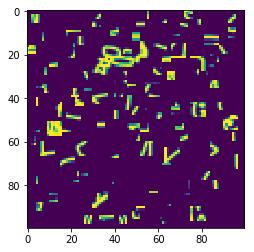

In [60]:
train_image1       = (train_features[2]).reshape(100,100)
plt.imshow(train_image1)

### Nettoyage des données

In [61]:
X_new=filterimg(train_features)
X_test=filterimg(test_features)

### Echantillion : Examiner la meme image apres le traitement ( centrée+debruitée )

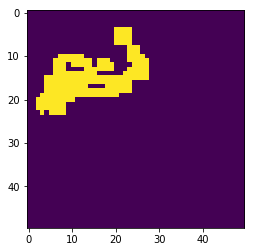

In [62]:
train_image1       = (X_new[2]).reshape(50,50)
plt.imshow(train_image1)

### Recherches des valeur manquantes

In [63]:
imputer = Imputer(strategy='median') 
imputer.fit(X_new)
X = imputer.transform(X_new)
X_test = imputer.transform(X_test)

In [64]:
print('Valeurs manquantes dans les donnees d entrainement : ', np.sum(np.isnan(X)))
print('Valeurs manquantes dans les donnees de test : ', np.sum(np.isnan(X_test)))

Valeurs manquantes dans les donnees d entrainement :  0
Valeurs manquantes dans les donnees de test :  0


In [65]:
#s'assurer que toutes les valeurs sont finies
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [83]:
y = np.array(train_labels).reshape((-1, ))
#y_test = np.array(test_labels).reshape((-1, ))
print(y)

['shovel' 'rifle' 'scorpion' ... 'rollerskates' 'mouth' 'pencil']


### Normalisation des donnees :

La normalisation des données est une etape importante dans la preparation des données dans l'aprentissage automatique. Elle a pour objectif de les valeurs des colonnes numériques dans la dataset afin d'utiliser une échelle commune,sans distoiotsion des difference dans les intervalles des valeur ni perte d'informations.

In [77]:
#Creation d'un objet de normalization dans un intervalle de 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting les donnees d'entrainement
scaler.fit(X)

# Transformation des donnees d'entrainement et de Test
X = scaler.transform(X)
X_test = scaler.transform(X_test)

### Modeles a tester

    1.Linear Regression
    2.Support Vector Machine Regression
    3.Random Forest Regression
    4.Gradient Boosting Regression
    5.K-Nearest Neighbors Regression


In [80]:
# Function to calculate mean absolute error
#def mae(y_true, y_pred):
    #return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute c.est la y_pred
    model_pred = model.predict(X_test)
    
    #model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    #return model_mae
    return model_pred

In [81]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

ValueError: could not convert string to float: 'shovel'